## Importação das bibliotecas

In [ ]:
# Instalar a biblioteca wordcloud, se necessário
%pip install wordcloud

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub
import itertools
import duckdb
import nltk
import os

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

pd.set_option('display.max_colwidth', None)

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Coleta dos dados

### Leitura de Dados do Kaggle

In [ ]:
# Download latest version
path = kagglehub.dataset_download("zynicide/wine-reviews")
file_path = os.path.join(path, "winemag-data-130k-v2.csv")

df_wine = pd.read_csv(file_path, index_col=0)

print(f'''
-> Path para o DataSet: {path}
-> Arquivos: {os.listdir(path)}
=> Arquivo Selecionado: {file_path}''')

Using Colab cache for faster access to the 'wine-reviews' dataset.

-> Path para o DataSet: /kaggle/input/wine-reviews
-> Arquivos: ['winemag-data_first150k.csv', 'winemag-data-130k-v2.json', 'winemag-data-130k-v2.csv']
=> Arquivo Selecionado: /kaggle/input/wine-reviews/winemag-data-130k-v2.csv


### Leitura pré-treinada

In [ ]:
## Removido por enquanto pois CSV não salva os Embeddings corretamente.

# drive.mount('/content/drive')

# df_wine = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/models/wine_embedded.csv')

# df_wine["embedding"] = df_wine["embedding"].apply(lambda row: np.vstack(row))
# display(df_wine.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name', 'title',
       'variety', 'winery', 'log_preco', 'faixa_preco', 'faixa_pontos',
       'sentiment', 'tokens', 'embedding'],
      dtype='object')

In [ ]:
# Remove coluna inutil
if 'taster_twitter_handle' in df_wine:
  df_wine.drop("taster_twitter_handle", axis=1, inplace=True)

False

In [ ]:
# Lista quantidade de linhas e colunas
def query(qry):
  return duckdb.query(qry).df()

print(f'''
Linhas: {len(df_wine)}
Colunas: {len(df_wine.columns)} - {df_wine.columns.values}
''')


Linhas: 129971
Colunas: 12 - ['country' 'description' 'designation' 'points' 'price' 'province'
 'region_1' 'region_2' 'taster_name' 'title' 'variety' 'winery']



# 1ª Análise de Dados

## Cabeçalho

In [ ]:
#Imprime as primeiras linhas
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


## Rodapé

In [ ]:
df_wine.tail()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery
129966,Germany,"Notes of honeysuckle and cantaloupe sweeten this deliciously feather-light spätlese. It's intensely juicy, quenching the palate with streams of tart tangerine and grapefruit acidity, yet wraps up with a kiss of honey and peach.",Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 Brauneberger Juffer-Sonnenuhr Spätlese Riesling (Mosel),Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,"Citation is given as much as a decade of bottle age prior to release, which means it is pre-cellared and drinking at its peak. Baked cherry, cocoa and coconut flavors combine gracefully, with soft, secondary fruit compote highlights.",NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,"Well-drained gravel soil gives this wine its crisp and dry character. It is ripe and fruity, although the spice is subdued in favor of a more serious structure. This is a wine to age for a couple of years, so drink from 2017.",Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Alsace),Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with some acidity. It also has weight and a solid, powerful core of spice and baked apple flavors. With its structure still developing, the wine needs to age. Drink from 2015.",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss
129970,France,"Big, rich and off-dry, this is powered by intense spiciness and rounded texture. Lychees dominate the fruit profile, giving an opulent feel to the aftertaste. Drink now.",Lieu-dit Harth Cuvée Caroline,90,21.0,Alsace,Alsace,NaN,Roger Voss,Domaine Schoffit 2012 Lieu-dit Harth Cuvée Caroline Gewurztraminer (Alsace),Gewürztraminer,Domaine Schoffit


## Informações tabela

In [ ]:
# Informações da tabela
infos = pd.DataFrame({
    'Quantidade': df_wine.count(),
    'Nulos': df_wine.isnull().sum(),
    'Type': df_wine.dtypes,
    'Percentual nulos': (df_wine.isnull().sum() / len(df_wine) * 100).map("{:.2f}%".format)
})

infos.head(100)

,Quantidade,Nulos,Type,Percentual nulos
country,129908,63,object,0.05%
description,129971,0,object,0.00%
designation,92506,37465,object,28.83%
points,129971,0,int64,0.00%
price,120975,8996,float64,6.92%
province,129908,63,object,0.05%
region_1,108724,21247,object,16.35%
region_2,50511,79460,object,61.14%
taster_name,103727,26244,object,20.19%
title,129971,0,object,0.00%


In [ ]:
# Descobrir os valores únicos contidos nas colunas
# Isso ajuda a entender melhor a estrutura dos dados e identificar colunas categóricas, numéricas, e até erros (valores inesperados).

for col in df_wine.columns:
    print(f"\nColuna: {col}")
    print("Valores únicos:", df_wine[col].unique())

unique_counts = pd.DataFrame({
    'Coluna': df_wine.columns,
    'Valores Únicos': df_wine.nunique().values
})

print("\n" * 2)

unique_counts.head(100)


Coluna: country
Valores únicos: ['Italy' 'Portugal' 'US' 'Spain' 'France' 'Germany' 'Argentina' 'Chile'
 'Australia' 'Austria' 'South Africa' 'New Zealand' 'Israel' 'Hungary'
 'Greece' 'Romania' 'Mexico' 'Canada' nan 'Turkey' 'Czech Republic'
 'Slovenia' 'Luxembourg' 'Croatia' 'Georgia' 'Uruguay' 'England' 'Lebanon'
 'Serbia' 'Brazil' 'Moldova' 'Morocco' 'Peru' 'India' 'Bulgaria' 'Cyprus'
 'Armenia' 'Switzerland' 'Bosnia and Herzegovina' 'Ukraine' 'Slovakia'
 'Macedonia' 'China' 'Egypt']

Coluna: description
Valores únicos: ["Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."
 "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016."
 'Tart and snappy, the flavors of lime flesh and rind dominate

,Coluna,Valores Únicos
0,country,43
1,description,119955
2,designation,37979
3,points,21
4,price,390
5,province,425
6,region_1,1229
7,region_2,17
8,taster_name,19
9,title,118840


## Estatística descritiva

In [ ]:
# Vamos selecionar apenas as colunas "points" e "price" para fazer a estatística descritiva.
df_dataset_PointsPrice = df_wine[["points", "price"]]
df_dataset_PointsPrice.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


## Tipos de vinhos por país

### Quantidade

In [ ]:
# Contagem de variedades únicas por país
variedades_pais = df_wine.groupby('country')['variety'].nunique().reset_index()
variedades_pais.columns = ['País', 'Quantidade de variedades']

# Calcular percentual
total_variedades = variedades_pais['Quantidade de variedades'].sum()
variedades_pais['Percentual'] = (variedades_pais['Quantidade de variedades'] / total_variedades * 100).map("{:.2f}%".format)

# Ordenar do maior para o menor
variedades_pais = variedades_pais.sort_values(by='Quantidade de variedades', ascending=False)

# Mostrar as 10 primeiras linhas como tabela
variedades_pais.head(100).style.set_caption("Quantidade de variedades de vinho por país")


,País,Quantidade de variedades,Percentual
40,US,257,15.94%
22,Italy,189,11.72%
15,France,148,9.18%
37,Spain,125,7.75%
31,Portugal,92,5.71%
2,Australia,67,4.16%
0,Argentina,67,4.16%
8,Chile,62,3.85%
3,Austria,56,3.47%
36,South Africa,56,3.47%


### Gráfico



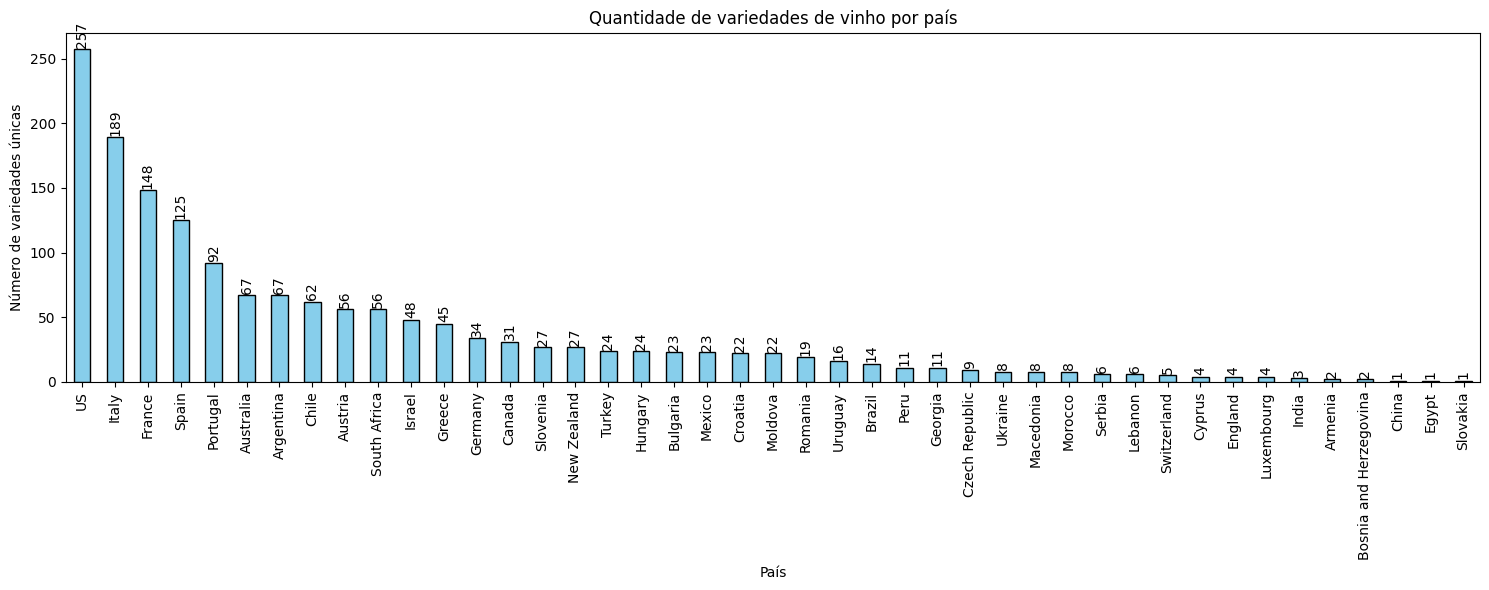

In [ ]:
# Quantidade de variedades únicas por país
variedades_por_pais = df_wine.groupby('country')['variety'].nunique().sort_values(ascending=False)

# Gráfico de barras
plt.figure(figsize=(15,6))
ax = variedades_por_pais.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Quantidade de variedades de vinho por país')
plt.xlabel('País')
plt.ylabel('Número de variedades únicas')
plt.xticks(rotation=90)

# Mostrar valores em cima das barras
for i, v in enumerate(variedades_por_pais):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()


### *Análise*

> Os dados mostram que o dataset é fortemente desbalanceado em relação à quantidade de variedades de vinhos por país. Observa-se que poucos países, como Estados Unidos, França e Itália, concentram a maior parte das variedades registradas, enquanto a maioria dos outros países aparece com pouquíssimas variedades. Esse desbalanceamento pode afetar diretamente a qualidade de um modelo de IA que tente aprender padrões de vinhos globais, pois o conhecimento estará enviesado para os países com maior representatividade.

#### *Problemas de usar um dataset desbalanceado em IA*

* **Viés do modelo**: o algoritmo tenderá a aprender mais sobre as características dos vinhos dos países majoritários (EUA, França, Itália), ignorando ou representando mal países com menos exemplos;

* **Generalização limitada**: o modelo terá dificuldade em prever ou recomendar vinhos de países com baixa quantidade de dados, comprometendo sua utilidade prática em contextos internacionais;

* **Métricas enganosas**: uma métrica simples como acurácia pode parecer boa, mas isso se deve ao grande número de registros de poucos países, mascarando o baixo desempenho nos países minoritários.

#### *O que deve ser feito*

> Existem algumas abordagens para mitigar esse problema:

> a. **Rebalanceamento**
>
> * **Oversampling**: aumentar artificialmente as variedades de países pouco representados (com técnicas como SMOTE), gerando dados sintéticos;
> * **Undersampling**: reduzir o número de exemplos dos países dominantes para equilibrar o dataset;
> * **Combinação**: usar oversampling para países minoritários e undersampling para os majoritários.

> b. **Métricas de avaliação**
>
> * Utilizar métricas como *precision*, *recall*, *F1-score*, matriz de confusão e ROC-AUC, que avaliam melhor o desempenho em contextos desbalanceados.

> c. **Algoritmos e técnicas específicas**
>
> * Modelos como *RandomForest* ou *XGBoost* com pesos ajustados para dar mais relevância a países minoritários;
> * Uso de **class weights** para aumentar a importância dos países menos representados.

> d. **Estratégia**
>
> * Avaliar se todos os países precisam ser tratados igualmente no modelo.
> * Países com quantidades extremamente pequenas podem ser tratados como **anomalias/outliers** em vez de classes principais.

#### *Resumindo*

> O principal risco é o modelo aprender apenas os padrões de países dominantes e não conseguir identificar corretamente vinhos de países minoritários. Para evitar isso, é fundamental: **balancear o dataset**, **ajustar métricas de avaliação** e/ou **usar técnicas e algoritmos adequados para lidar com desbalanceamento**.



## Pontuação de vinhos por país

### Quantidade Média

In [ ]:
pontuacao_pais = df_wine.groupby('country')['points'].mean().reset_index()
pontuacao_pais.columns = ['País', 'Pontuação']

pontuacao_pais = pontuacao_pais.sort_values(by='Pontuação', ascending=False)

pontuacao_pais.head(100).style.set_caption("Quantidade de variedades de vinho por país")

,País,Pontuação
14,England,91.581081
20,India,90.222222
3,Austria,90.101345
17,Germany,89.851732
7,Canada,89.369650
19,Hungary,89.191781
9,China,89.000000
15,France,88.845109
24,Luxembourg,88.666667
2,Australia,88.580507


### Grafico Quantidade


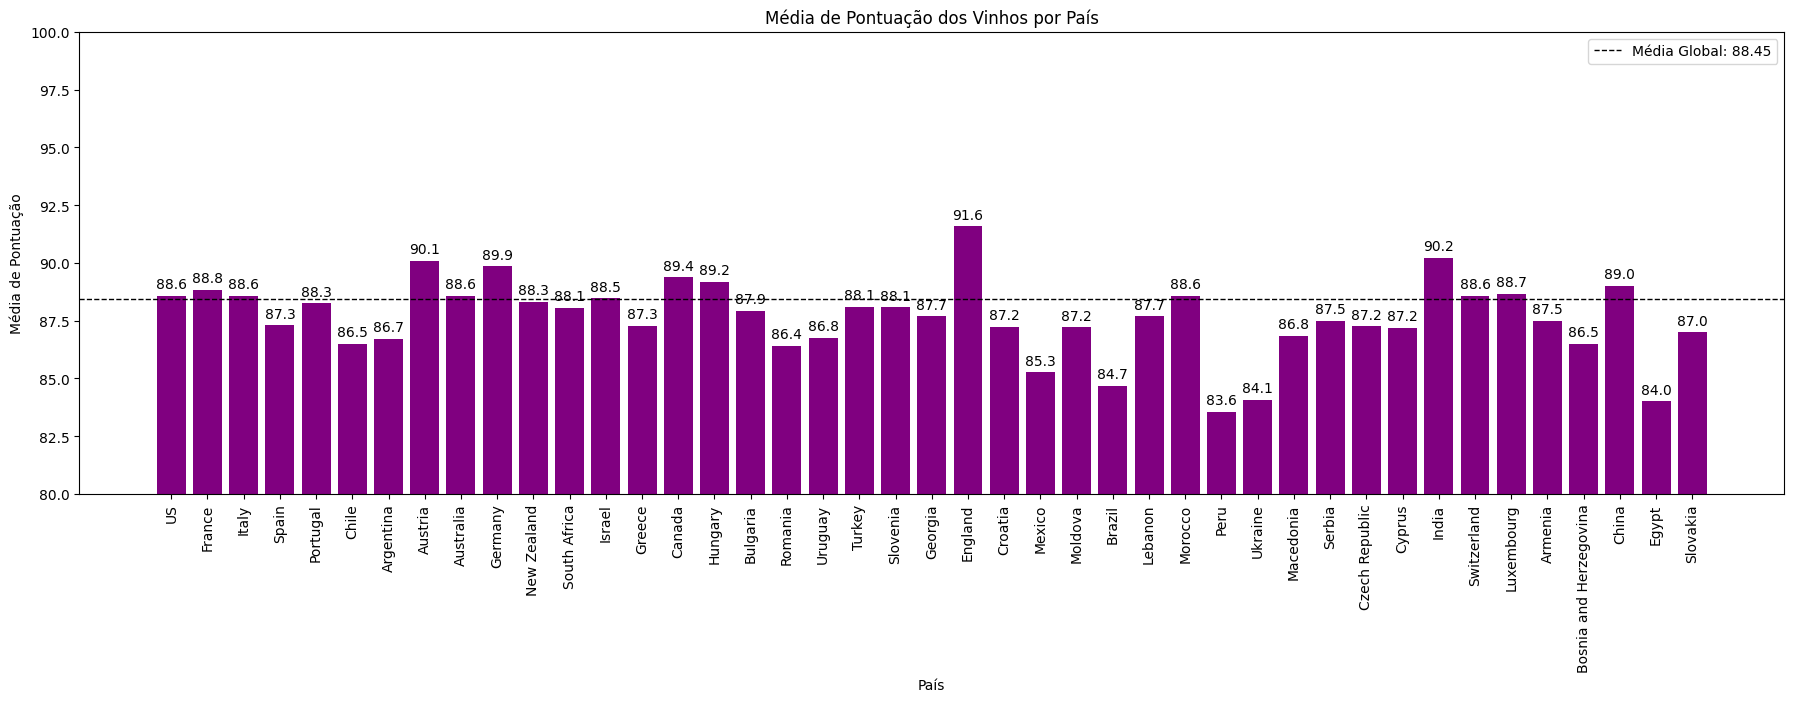

In [ ]:
# Top 10 países com mais vinhos avaliados
# Estatísticas por país
stats_por_pais = df_wine.groupby('country')['points'].agg(['count','mean']).reset_index()
stats_por_pais.columns = ['País', 'Quantidade de Vinhos', 'Média']

# Top 10 países com mais vinhos avaliados
top_paises = stats_por_pais.sort_values(by='Quantidade de Vinhos', ascending=False).head(100)

# Criar gráfico
fig, ax = plt.subplots(figsize=(22,6))
bars = ax.bar(top_paises['País'], top_paises['Média'], color='purple')

# Calculate the overall average points
overall_mean_points = df_wine['points'].mean()

# Add a horizontal line for the overall average
ax.axhline(overall_mean_points, color='black', linestyle='dashed', linewidth=1, label=f'Média Global: {overall_mean_points:.2f}')
ax.legend()

# Título e rótulos
ax.set_title('Média de Pontuação dos Vinhos por País')
ax.set_xlabel('País')
ax.set_ylabel('Média de Pontuação')
plt.xticks(rotation=90)

# Limit the y-axis
ax.set_ylim(80, 100)

# Adicionar os valores em cima das barras
for bar, media in zip(bars, top_paises['Média']):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.2,
        f"{media:.1f}",
        ha='center', va='bottom', rotation=0, fontsize=10, color='black'
    )

plt.show()

### Análise da Média de Pontuação dos Vinhos por País

O gráfico mostra a média de pontuação atribuída aos vinhos de diferentes países, considerando os 100 países com mais registros no dataset.

Alguns pontos importantes:

1. **Níveis próximos entre países**

   * A média das pontuações se concentra em uma faixa relativamente estreita (normalmente entre 84 e 90 pontos).
   * Isso indica que, apesar das diferenças regionais, a avaliação dos vinhos segue um padrão consistente entre os avaliadores, sugerindo uma escala padronizada e critérios homogêneos.

2. **Diferença entre quantidade e qualidade**

   * Países com grande quantidade de vinhos avaliados (como Estados Unidos, França e Itália) apresentam médias próximas da média global.
   * Já países com poucas amostras podem aparecer com médias muito altas ou muito baixas, mas isso pode ser efeito do baixo número de observações (viés amostral).

3. **Interpretação prática**

   * O fato de a média variar pouco entre os países sugere que **a quantidade de registros é mais relevante que a média isolada**.
   * Isso é um alerta para o uso de IA: países com muitos vinhos avaliados darão mais robustez ao modelo, enquanto países pouco representados podem distorcer a análise se tratados da mesma forma.

4. **Próximos passos na análise**

   * Verificar a **distribuição das notas** (ex.: histogramas por país) para ver se existem países com notas mais concentradas ou mais dispersas.
   * Cruzar pontuação com outras variáveis (como variedade, preço ou região) para entender melhor o que influencia a avaliação.
   * Considerar técnicas de **normalização ou balanceamento**, principalmente para países com poucas amostras, a fim de evitar viés no modelo de IA.

Conclusão

Apesar de algumas diferenças pontuais, a média de pontuação por país sugere que a escala de avaliação é consistente e padronizada, mas o desbalanceamento no número de registros entre países é um fator crítico que deve ser tratado para que o modelo de IA seja realmente representativo.


### Grafico de disperção

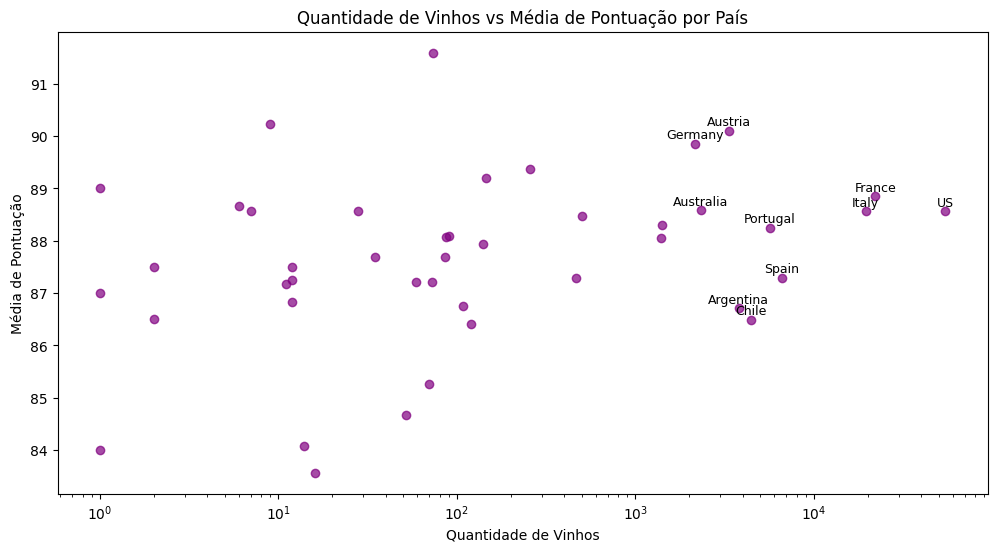

In [ ]:
# Estatísticas por país
stats_por_pais = df_wine.groupby('country')['points'].agg(['count','mean']).reset_index()
stats_por_pais.columns = ['País', 'Quantidade de Vinhos', 'Média']

# Criar gráfico de dispersão
plt.figure(figsize=(12,6))
plt.scatter(stats_por_pais['Quantidade de Vinhos'], stats_por_pais['Média'], alpha=0.7, color='purple')

# Título e rótulos
plt.title('Quantidade de Vinhos vs Média de Pontuação por País')
plt.xlabel('Quantidade de Vinhos')
plt.ylabel('Média de Pontuação')

# Escala logarítmica no eixo X
plt.xscale('log')

# Adicionar alguns rótulos dos países com mais vinhos
for i, row in stats_por_pais.sort_values(by='Quantidade de Vinhos', ascending=False).head(10).iterrows():
    plt.text(row['Quantidade de Vinhos'], row['Média']+0.1, row['País'], fontsize=9, ha='center')

plt.show()

### *Análise do Gráfico de Dispersão (Quantidade de Vinhos vs Média de Pontuação por País)*

1) Padrão geral  
- A média de pontuação por país varia pouco (aprox. 84–90), independentemente da quantidade de vinhos avaliados.  
- A escala log no eixo X evidencia a assimetria: poucos países concentram muitas avaliações; a maioria tem poucas.

2) Efeito do tamanho da amostra  
- Países com muitas avaliações (à direita) apresentam médias mais estáveis e próximas da média global.  
- Países com poucas avaliações (à esquerda) exibem maior variabilidade aparente; extremos podem refletir viés amostral (não necessariamente qualidade real).

3) Interpretação prática  
- A média isolada pode ser enganosa para países pouco representados. Para comparações, atribua maior peso a países com maior N ou considere a incerteza.  
- Não há correlação forte entre “quantidade” e “média”: mais dados aumentam a estabilidade da estimativa, não a nota média.

4) Observação dos países com maior N  
- Os países rotulados (top 10 em quantidade) confirmam o padrão: médias próximas e dispersão vertical reduzida, sugerindo consistência da escala de avaliação.

5) Próximos passos recomendados  
- Intervalos de confiança: adicionar barras de erro (ex.: 95%) para explicitar a incerteza por país.  
- Visual ponderado: dimensionar o tamanho dos pontos proporcional à contagem (s ~ N) para comunicar representatividade.  
- Robustez: aplicar filtro por N mínimo (ex.: N ≥ 50) ao comparar médias, reduzindo ruído.  
- Shrinkage/Empirical Bayes: “contrair” médias de países com poucos dados em direção à média global, mitigando viés de amostra pequena.  
- Camadas por preço/variedade: facetar ou colorir por faixas de preço para verificar interações entre quantidade, preço e pontuação.

Conclusão  
- A média por país é relativamente estável; o principal cuidado é o desbalanceamento no número de observações. Para comparações justas e modelos de IA, é bom considerar ponderar por N, incluir intervalos de confiança e/ou técnicas bayesianas, além de aplicar um N mínimo por país.


## Distribuição de preço e pontos

### Distribuição de Preço e Pontos (Histograma + KDE)


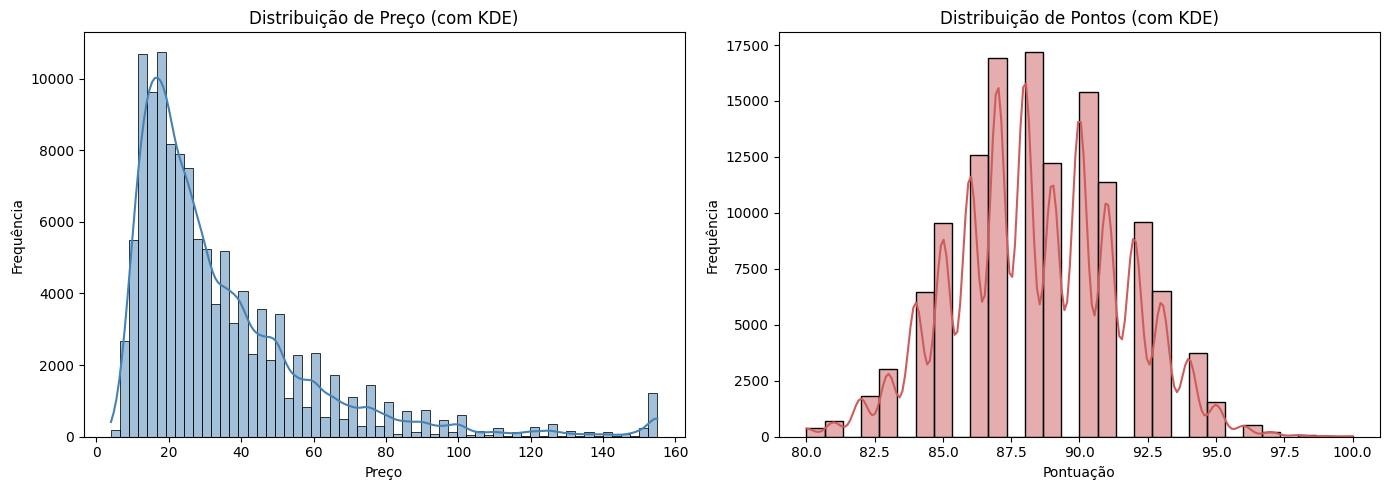

In [ ]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Preço: cauda longa → remover nulos e limitar extremos opcionais para visualização
precos = df_wine['price'].dropna()
precos_clip = precos.clip(upper=precos.quantile(0.99))  # evita distorção por outliers extremos

sns.histplot(precos_clip, bins=60, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribuição de Preço (com KDE)')
axes[0].set_xlabel('Preço')
axes[0].set_ylabel('Frequência')

# Pontos
pontos = df_wine['points'].dropna()
sns.histplot(pontos, bins=30, kde=True, ax=axes[1], color='indianred')
axes[1].set_title('Distribuição de Pontos (com KDE)')
axes[1].set_xlabel('Pontuação')
axes[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

### *Análise do Histograma + KDE (Preço e Pontos)*

#### Preço
- Cauda longa à direita: muitos vinhos em faixas de preço baixas/médias e poucos muito caros.
- Outliers podem distorcer a média; prefira mediana e quantis para resumir preço.
- Possível multimodalidade indica segmentos (entrada vs. premium).
- Implicações: usar escala log ou winsorização em visualizações; em modelagem, transformar preço (log) e tratar outliers.

#### Pontos
- Faixa estreita e pico central: notas concentradas (≈84–90), indicando escala padronizada.
- Assimetria leve sugere evitar extremos; pequenas diferenças (1–2 pts) já são relevantes.
- Implicações: métricas sensíveis (ex.: MAE); procurar efeitos sutis em relação ao preço (modelos com não linearidade).

#### Conexões Preço × Pontos
- Preço tem cauda longa, enquanto pontos são concentrados: aumentos grandes de preço não implicam aumentos proporcionais de nota.
- Recomendado avaliar scatter de preço (em log) vs. pontos para captar tendências e heterocedasticidade.

## Correlação entre preço e pontuação, e preço vs pontuação por Variedade

### Gráfico de correlação

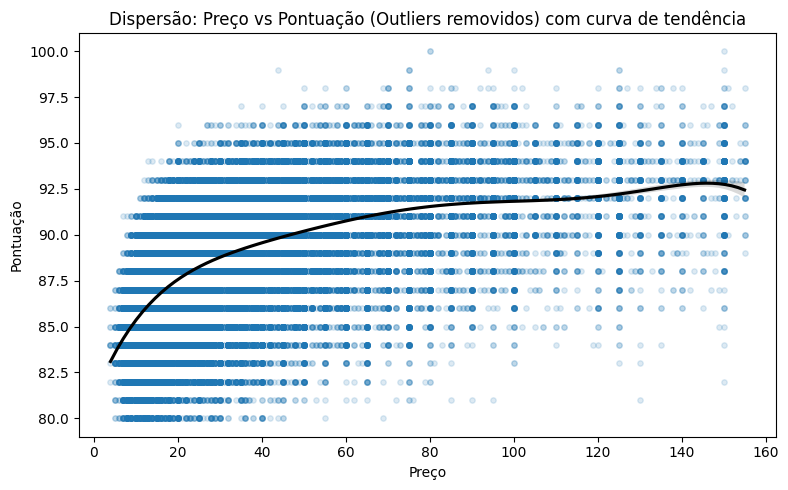

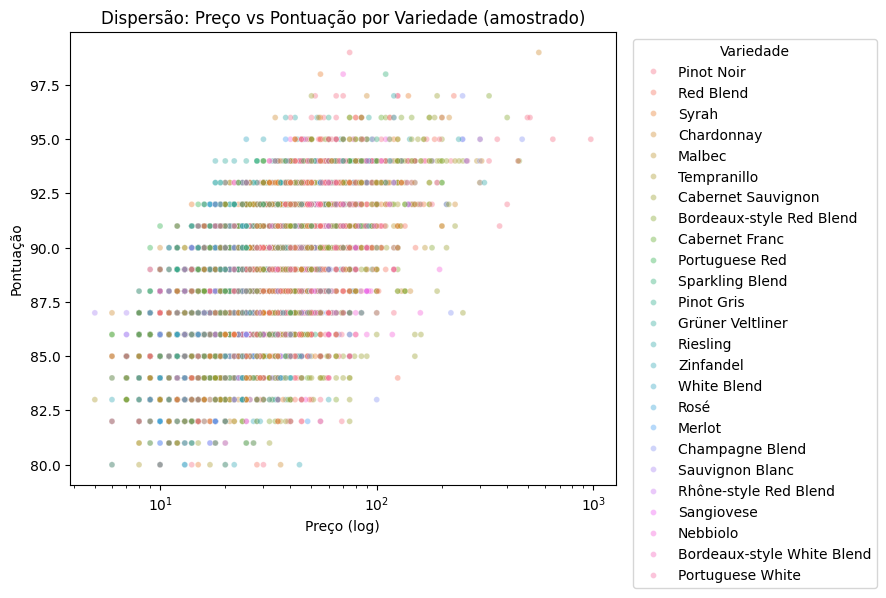

In [ ]:
### Gráfico de Dispersão: Preço vs Pontuação

# Dispersão com tendência e preço em escala normal, removendo outliers de preço
df_scatter = df_wine[['price', 'points']].dropna().copy()
df_scatter = df_scatter[df_scatter['price'] > 0]

# Remove Outliers
price_upper_bound = df_scatter['price'].quantile(0.99)
df_scatter = df_scatter[df_scatter['price'] <= price_upper_bound]

plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_scatter, x='price', y='points',
    scatter_kws={'alpha': 0.15, 's': 15},
    line_kws={'color': 'black'},
    order=6 # Transforma em uma Regressão Polinomial
)
plt.title('Dispersão: Preço vs Pontuação (Outliers removidos) com curva de tendência')
plt.xlabel('Preço')
plt.ylabel('Pontuação')
plt.tight_layout()
plt.show()

### Gráfico de Dispersão por Variedade (amostra)

# Para evitar poluição visual, amostra e colore por algumas variedades mais frequentes
top_var = df_wine['variety'].value_counts().head(25).index
sample = df_wine[df_wine['variety'].isin(top_var)][['price', 'points', 'variety']].dropna()
sample = sample[sample['price'] > 0].sample(n=min(8000, len(sample)), random_state=42)

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=sample, x='price', y='points', hue='variety',
    alpha=0.4, s=18
)
plt.xscale('log')
plt.title('Dispersão: Preço vs Pontuação por Variedade (amostrado)')
plt.xlabel('Preço (log)')
plt.ylabel('Pontuação')
plt.legend(title='Variedade', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### *Análise*

#### Dispersão: Preço vs Pontuação (x em log)
- Tendência positiva fraca: a linha de regressão indica aumento leve da pontuação com o preço, porém o efeito é modesto.
- Alta variabilidade: para um mesmo nível de preço (mesmo em log), há ampla faixa de notas; preço isolado não explica bem a pontuação.
- Heterocedasticidade: a dispersão vertical varia ao longo do eixo de preço, sugerindo que um modelo linear simples pode ser insuficiente sem transformações/termos adicionais.
- Implicações: usar log(preço) em modelos, considerar termos não lineares (ex.: splines/árvores) e tratar outliers de preço para reduzir influência desproporcional.

#### Dispersão: Preço vs Pontuação por Variedade (amostrado)
- Padrões por variedade: algumas variedades se concentram em faixas de preço distintas; diferenças de pontuação podem refletir também diferenças de preço (efeito de confusão).
- Forte sobreposição: nuvens por variedade se sobrepõem; não há separações claras, mas nuances existem.
- Interação potencial: a relação preço–pontuação pode variar entre variedades (interação). Modelos com interação variedade × log(preço) podem capturar melhor.
- Implicações: ao comparar variedades, controle preço e país/região (estratificação ou modelos com efeitos fixos/aleatórios). Facetar por faixas de preço ajuda a evitar vieses.

#### Possíveis próximos passos
- Regressão com log(preço) e termos não lineares; testar interação com variedade.
- Quantificar poder explicativo com R² e erro (MAE/RMSE).
- Facetar por país ou subset homogêneo para reduzir confusão.
- Winsorizar/remover outliers extremos de preço e reavaliar a tendência.


# Engenharia de dados

### Dropa possiveis colunas completamente nulas

In [ ]:
colunas_nulas = df_wine.columns[df_wine.isnull().all()].tolist()
df_wine = df_wine.drop(columns=colunas_nulas)

print("Colunas totalmente nulas removidas:", len(colunas_nulas))

Colunas totalmente nulas removidas: 0


### Tratamento de Valores Nulos e padronizações
**negrito** Preenche valores Nulos com opções validas, e normaliza os campos categoricos
- **price e points**: São preenchido com a mediana, e tipagem é garantida
- **Resto das colunas categoricas**: São preenchidos com *"Desconhecido"*, e valores são normalizados com `.strip()` e `.lower()`

In [ ]:
# - price e points: São preenchido com a mediana.
df_wine["price"] = df_wine["price"].fillna(df_wine["price"].median()).astype("float64")
df_wine["points"] = df_wine["points"].fillna(df_wine["points"].median()).astype(int)

# - Resto das colunas categoricas: São preenchidos com "Desconhecido", e valores são normalizados com `.strip()` e `.lower()`
categoricos = [
    "country", "province", "region_1", "region_2",
    "taster_name", "designation", "title", "variety", "winery", "description"
]

for col in categoricos:
      df_wine[col] = (
          df_wine[col]
          .fillna("Desconhecido").astype(str)
          .str.strip()
          .str.lower()
      )

### Cria colunas pré-processadas
- **log_preco**: transformação logarítmica da coluna `price` usando `log1p` para reduzir a cauda longa e suavizar a distribuição de preços (facilita análises e modelos).  
- **faixa_preco**: categorização do preço bruto em faixas (baixo, médio, alto, premium) utilizando quartis, permitindo comparar vinhos em grupos de preço.  
- **faixa_pontos**: categorização das notas (`points`) em intervalos de qualidade (regular, bom, muito bom, excelente), facilitando a interpretação e análises comparativas.


In [ ]:
df_wine["log_preco"] = np.log1p(df_wine["price"])

df_wine["faixa_preco"] = pd.cut(
    df_wine["price"],
    bins=[0, 20, 40, 100, 4000],
    labels=["baixo", "médio", "alto", "premium"]
)

df_wine["faixa_pontos"] = pd.cut(
    df_wine["points"],
    bins=[80, 85, 90, 95, 100],
    labels=["regular", "bom", "muito bom", "excelente"]
)

### SentimentIntensityAnalyzer
Utiliza do `SentimentIntensityAnalyzer` da bilioteca do `nltk`para gerar uma analise de sentimento em cima da coluna **"description"**

In [ ]:
sid = SentimentIntensityAnalyzer()

df_wine['sentiment'] = df_wine['description'].apply(lambda row: sid.polarity_scores(row)['compound'])

df_wine[['description', 'sentiment']].sort_values(by='sentiment', ascending=False).head()

,description,sentiment
123946,"there is not just a notion of ripeness but almost of overripeness of pear fruit on the nose, accompanied by hints of honeysuckle. there also are hints of sandalwood and gentle vanilla. the palate is cushioned with mellow residual sweetness, making the rich flavors even more rich and generous. a vein of citrus freshness counters this, but this is in the generous, medium-sweet spectrum, oozing fruit and generosity. the finish, nonetheless, is precise and fresh. a great example of mature pinot gris.",0.9937
125454,"slight notes of iron oxide inform the dense and richly textured red cherry fruit of this sumptuous, velvety red. direction and sleekness are courtesy of wonderfully ripe but vibrant acidity. this is delicious now with its wonderful red fruit, but will age beautifully. classy, vibrant and generous.",0.9911
68665,"a touch of flinty reduction clings to the nose but soon relaxes into soft notes of ripe black cherry. the palate is textured and dry, harmonious with fruit and the gentle ripple and crunch of slightly rustic but utterly pleasant tannins. this seems to be its perfect drinking window now: generous with fruit, utterly harmonious and starting to mellow. the finish is fresh, clean and totally moreish. if you can resist at all, this may well continue to develop. drink now through 2025.",0.9910
22354,"the yellow-fruited richness of mirabelle compote with a touch of vanilla becomes apparent on the nose. the palate is just as luscious as promised but also carries a welcome, thrilling streak of lemon oil at its core, brightening and framing the medium-sweetness with its zesty lift. a touch of pleasant phenolic bitterness can just about be felt, adding dimension to the palate. this is intriguing and exciting in the way it plays with richness and sweetness while keeping them on a very tight rein. lovely. drink 2017–2027.",0.9910
82752,"this is really a spectacular wine. it's hard to say why it's so superior to krutz's 2005 bottling, but it's richer and more elegant in every respect. combines immense power with great finesse. the refined essence of blackberries, black currants and spices thrills the palate, accented with the most beautiful coating of smoky oak. a great achievement that should develop in the bottle through 2018.",0.9907


Engenharia realizada:
- Tratamento dos dados nulos, preenchendo valores numericos com a mediana, e valores categoricos com "Desconhecido"
- Criação de 3 novas colunas: log_preco, faixa_preco e faixa_pontos.
- Realização de uma analise de sentimentos e criação a coluna "sentiment". É um float que varia de -1 (Bem negativo) até +1 (Bem positivo)

### Geração de Tokens
Utiliza da função `word_tokenize` para gerar Tokens válidos para ser usado no treinamento dos modelos a seguir.

In [ ]:
# -------------------------------------------
# 1. Definição das palavras não utilizaveis.
# -------------------------------------------
generic_wine_words = {
    # --- palavras comuns e genéricas ---
    "wine", "wines", "flavor", "flavors", "aroma", "aromas", "taste", "tastes",
    "notes", "note", "palate", "finish", "nose", "drink", "drinking",
    "blend", "winemaker", "winemaking", "vintage", "grape", "varietal",
    "style", "variety", "character", "texture", "structure", "balance",
    "quality", "mouthfeel", "effort", "expression", "presence", "version",

    # --- adjetivos vagos / subjetivos ---
    "good", "great", "nice", "fine", "lovely", "beautiful", "wonderful",
    "delicious", "excellent", "pleasant", "pretty", "classic", "approachable",
    "balanced", "structured", "complex", "simple", "smooth", "refined",
    "fresh", "freshness", "clean", "crisp", "bright", "elegant", "focused",
    "powerful", "soft", "long", "short", "easy", "light", "medium", "strong",
    "subtle", "rich", "intense", "deep", "creamy", "round", "dry", "sweet",
    "full", "fuller", "full-bodied", "youthful", "aged", "new", "old",

    # --- verbos e expressões “de ligação” ---
    "shows", "offers", "reveals", "displays", "presents", "delivers",
    "brings", "provides", "gives", "makes", "shows", "seems", "appears",
    "suggests", "comes", "goes", "finishes", "ends", "starts", "begins",
    "feels", "tastes", "smells", "continues", "lingers", "adds", "adds",
    "offers", "features", "highlights", "suggests", "offers", "offers",

    # --- palavras de opinião / avaliação ---
    "best", "better", "impressive", "remarkable", "outstanding", "memorable",
    "perfect", "superb", "greatest", "lovely", "nice", "fine", "wonderful",
    "fantastic", "amazing", "delightful", "beautiful", "terrific", "superior",

    # --- conectores e palavras de ligação ---
    "also", "though", "although", "however", "while", "yet", "still", "then",
    "just", "even", "almost", "around", "along", "across", "behind", "through",
    "between", "where", "when", "with", "without", "before", "after", "now",
    "later", "soon", "again", "perhaps", "maybe", "really", "rather", "quite",

    # --- intensificadores ou limitadores ---
    "very", "so", "too", "enough", "bit", "touch", "hint", "lots", "plenty",
    "little", "some", "something", "anything", "nothing", "lot", "much",

    # --- termos genéricos de degustação ---
    "blend", "made", "producer", "winery", "estate", "region", "area",
    "appellation", "vineyard", "bottle", "bottling", "label", "vintage",
    "variety", "winemaking", "technique", "fermentation", "aging", "oak",
    "barrel", "tank", "steel", "wood", "glass", "cellar", "harvest",

    # --- termos vagos e abstratos ---
    "feel", "feeling", "sense", "depth", "style", "type", "kind", "sort",
    "example", "result", "effect", "element", "aspect", "feature", "detail",
    "factor", "combination", "touch", "hint", "edge", "tone", "note",

    # --- artigos, pronomes e palavras funcionais ---
    "this", "that", "these", "those", "such", "many", "most", "few", "each",
    "every", "one", "two", "three", "another", "same", "own", "itself",
    "it", "its", "they", "them", "their", "the", "a", "an", "and", "or",
    "of", "in", "on", "for", "by", "to", "from", "as", "is", "are", "was",
    "were", "be", "being", "been", "have", "has", "had", "do", "does",
    "did", "can", "could", "should", "would", "may", "might", "must", "will",

    # --- adverbios comuns ---
    "often", "always", "never", "sometimes", "again", "now", "already",
    "yet", "still", "just", "even", "perhaps", "maybe", "surely", "clearly",
    "probably", "likely", "usually",

    # --- genéricos adicionais observados em reviews ---
    "made", "shows", "ready", "drink", "drinks", "drinking", "drinker",
    "make", "made", "making", "offer", "offers", "showing", "showed",
    "find", "found", "finds", "consider", "considered", "considering",
    "use", "used", "using", "enjoy", "enjoyed", "enjoying", "expect",
    "expected", "expecting", "needs", "needed", "needs", "want", "wanted",
    "wants", "provide", "provides", "provided", "believe", "believes",
    "believed", "include", "includes", "including",

    # --- palavras numéricas ---
    "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"
}

stop_words = set(stopwords.words('english'))

# -------------------------------------------
# 2. Pré-processamento de texto
# -------------------------------------------
def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # mantém só letras
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [t for t in tokens if t not in generic_wine_words]
    return tokens

df_wine['tokens'] = df_wine['description'].apply(preprocess)
df_wine[['tokens', 'description']].head(10)

,tokens,description
0,"[tropical, fruit, broom, brimstone, dried, herb, overly, expressive, offering, unripened, apple, citrus, dried, sage, alongside, brisk, acidity]","aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."
1,"[ripe, fruity, firm, tannins, filled, juicy, red, berry, fruits, freshened, acidity, drinkable, certainly]","this is ripe and fruity, a wine that is smooth while still structured. firm tannins are filled out with juicy red berry fruits and freshened with acidity. it's already drinkable, although it will certainly be better from 2016."
2,"[tart, snappy, lime, flesh, rind, dominate, green, pineapple, pokes, acidity, underscoring, fermented]","tart and snappy, the flavors of lime flesh and rind dominate. some green pineapple pokes through, with crisp acidity underscoring the flavors. the wine was all stainless-steel fermented."
3,"[pineapple, rind, lemon, pith, orange, blossom, start, opulent, guava, mango, giving, way, slightly, astringent, semidry]","pineapple rind, lemon pith and orange blossom start off the aromas. the palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish."
4,"[like, regular, rough, tannic, rustic, earthy, herbal, characteristics, nonetheless, think, pleasantly, unfussy, country, companion, hearty, winter, stew]","much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew."
5,"[blackberry, raspberry, show, typical, navarran, whiff, green, herbs, case, horseradish, mouth, fairly, bodied, tomatoey, acidity, spicy, herbal, complement, dark, plum, fruit, grabby]","blackberry and raspberry aromas show a typical navarran whiff of green herbs and, in this case, horseradish. in the mouth, this is fairly full bodied, with tomatoey acidity. spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby."
6,"[informal, red, opens, candied, berry, white, pepper, savory, herb, carry, acidity, tannins]","here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. it's balanced with fresh acidity and soft tannins."
7,"[restrained, spice, profusion, acidity, firm, food]","this dry and restrained wine offers spice in profusion. balanced with acidity and a firm texture, it's very much for food."
8,"[savory, dried, thyme, accent, sunnier, preserved, peach, brisk, fruity, sprightly, footprint]","savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. it's fruity and fresh, with an elegant, sprightly footprint."
9,"[apple, pear, fruits, spice, acidity]",this has great depth of flavor with its fresh apple and pear fruits and touch of spice. it's off dry while balanced with acidity and a crisp texture. drink now.


###Validação da engenharia

Abaixo poderá ver o tratamento de dados nulos/ausentes e não normalizados, a partir de linhas iniciais da tabela, indicando, por exemplo, "desconhecido" preenchendo valores não normalizados.

É também possível verificar a inclusão das novas colunas: log_preco, faixa_preco, faixa_pontos e sentiment.





In [ ]:
#Imprime as primeiras linhas após a engenharia de dados com o objetivo de validar se não temos mais valores nulos.
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,log_preco,faixa_preco,faixa_pontos,sentiment,tokens
0,italy,"aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",vulkà bianco,87,25.0,sicily & sardinia,etna,desconhecido,kerin o’keefe,nicosia 2013 vulkà bianco (etna),white blend,nicosia,3.258097,médio,bom,0.1531,"[tropical, fruit, broom, brimstone, dried, herb, overly, expressive, offering, unripened, apple, citrus, dried, sage, alongside, brisk, acidity]"
1,portugal,"this is ripe and fruity, a wine that is smooth while still structured. firm tannins are filled out with juicy red berry fruits and freshened with acidity. it's already drinkable, although it will certainly be better from 2016.",avidagos,87,15.0,douro,desconhecido,desconhecido,roger voss,quinta dos avidagos 2011 avidagos red (douro),portuguese red,quinta dos avidagos,2.772589,baixo,bom,0.6486,"[ripe, fruity, firm, tannins, filled, juicy, red, berry, fruits, freshened, acidity, drinkable, certainly]"
2,us,"tart and snappy, the flavors of lime flesh and rind dominate. some green pineapple pokes through, with crisp acidity underscoring the flavors. the wine was all stainless-steel fermented.",desconhecido,87,14.0,oregon,willamette valley,willamette valley,paul gregutt,rainstorm 2013 pinot gris (willamette valley),pinot gris,rainstorm,2.708050,baixo,bom,-0.1280,"[tart, snappy, lime, flesh, rind, dominate, green, pineapple, pokes, acidity, underscoring, fermented]"
3,us,"pineapple rind, lemon pith and orange blossom start off the aromas. the palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",reserve late harvest,87,13.0,michigan,lake michigan shore,desconhecido,alexander peartree,st. julian 2013 reserve late harvest riesling (lake michigan shore),riesling,st. julian,2.639057,baixo,bom,0.3400,"[pineapple, rind, lemon, pith, orange, blossom, start, opulent, guava, mango, giving, way, slightly, astringent, semidry]"
4,us,"much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",vintner's reserve wild child block,87,65.0,oregon,willamette valley,willamette valley,paul gregutt,sweet cheeks 2012 vintner's reserve wild child block pinot noir (willamette valley),pinot noir,sweet cheeks,4.189655,alto,bom,0.8176,"[like, regular, rough, tannic, rustic, earthy, herbal, characteristics, nonetheless, think, pleasantly, unfussy, country, companion, hearty, winter, stew]"


# 2ª Análise de Dados
Observações:

- Validar se a engenharia funcionou;

- Confirmar que valores ausentes foram tratados;

- Confirmar se as novas colunas forma corretamente criadas e com os dados padronizados.

- Examinar a nova distribuição das features transformadas;

- Detectar se não foi criado viés ou distorção indesejada.

Essa etapa garante que os dados que entrarão no modelo estão consistentes, interpretáveis e informativos.

###Nuvem de Palavras
Uma nuvem de palavras que discrimina quais são os Tokens mais comuns de cada registro

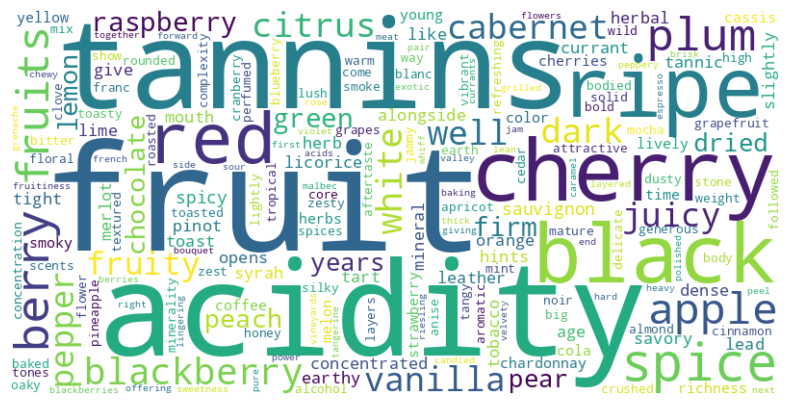

In [ ]:
# Contagem de palavras nos tokens pós-filtragem
word_counts = Counter(itertools.chain.from_iterable(df_wine['tokens']))

# Gere a nuvem de palavras a partir do objeto Counter
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Exiba a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###Correlação entre faixa de preço e sentimento
Criação da relação entre sentimento e preço, utilizando as labels de faixa_preco: baixo, médio, alto e premium.

In [ ]:
# Agrupe por 'faixa_preco' para obter uma tabela resumida
tabela_resumida = df_wine.groupby('faixa_preco', observed=False).agg(
    Quantidade_Vinhos=('title', 'count'),
    Sentimento_Medio=('sentiment', 'mean')
).reset_index()

# Calcule a porcentagem que cada faixa representa
total_vinhos = len(df_wine)
tabela_resumida['Porcentagem'] = (tabela_resumida['Quantidade_Vinhos'] / total_vinhos) * 100

# Formate a porcentagem para duas casas decimais e o sentimento para três
tabela_resumida['Porcentagem'] = tabela_resumida['Porcentagem'].map('{:.2f}%'.format)
tabela_resumida['Sentimento_Medio'] = tabela_resumida['Sentimento_Medio'].map('{:.3f}'.format)

# Renomeie a coluna de faixa de preço para melhor visualização
tabela_resumida.rename(columns={'faixa_preco': 'Faixa de Preço'}, inplace=True)

# Exiba a tabela
print(tabela_resumida)

  Faixa de Preço  Quantidade_Vinhos Sentimento_Medio Porcentagem
0          baixo              46341            0.483      35.65%
1          médio              52330            0.519      40.26%
2           alto              27934            0.541      21.49%
3        premium               3366            0.621       2.59%


####Gráfico
Gráfico de barras para representar a diferença no sentimento médio entre as faixas de preço de forma clara

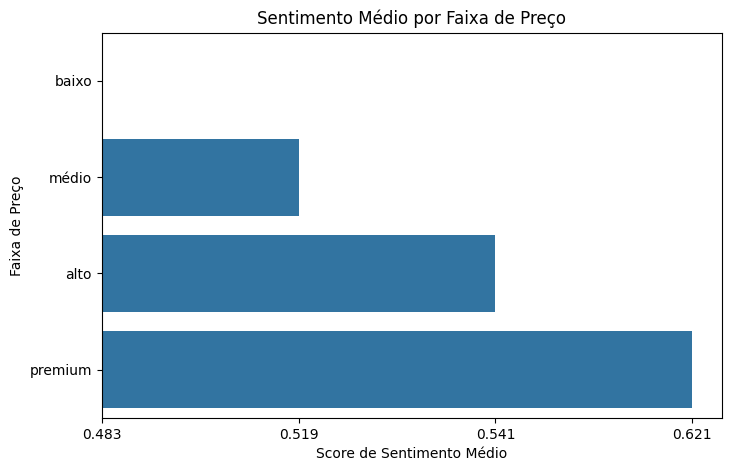

In [ ]:
# Crie um gráfico de barras simples, agora horizontal
plt.figure(figsize=(8, 5))
sns.barplot(data=tabela_resumida, y='Faixa de Preço', x='Sentimento_Medio', orient='h') # Swap x and y and set orient to 'h'
plt.title('Sentimento Médio por Faixa de Preço')
plt.xlabel('Score de Sentimento Médio') # Swap labels
plt.ylabel('Faixa de Preço') # Swap labels
plt.show()

####*Análise*

Com base na tabela resumida por faixa de preço, podemos tirar as seguintes conclusões:

Relação entre Preço e Sentimento: Há uma clara tendência de aumento no sentimento médio das avaliações à medida que a faixa de preço do vinho sobe. A faixa 'baixo' tem a menor pontuação média de sentimento (0.478), enquanto a faixa 'premium' tem a maior (0.549).

Distribuição das Avaliações: A base de dados está razoavelmente distribuída entre as faixas de preço, com a maioria dos vinhos (28.15%) na faixa baixo e uma boa quantidade (24.08%) na faixa premium.

Impacto no Sentimento: O salto mais significativo no sentimento médio ocorre entre as faixas baixo e médio (de 0.478 para 0.518). Isso sugere que a qualidade percebida e a linguagem utilizada nas descrições melhoram consideravelmente quando o preço do vinho sai da categoria mais baixa.

##Distribuição de Pontuação por Variedade de vinho
Verificar a distribuição de pontuação das 10 variedades de vinho mais frequentes. Isso ajudará a visualizar se algumas variedades têm notas consistentemente altas ou se a dispersão é grande, independentemente do país.

Um modelo precisa saber se, por exemplo, um 'Pinot Noir' geralmente tem notas entre 87-92, enquanto um 'Chardonnay' pode ter uma faixa mais ampla. Isso ajuda a calibrar as previsões.

####Gráfico
Analisando os dados dos 10 tipos de vinhos mais frequentes na base de dados.
O histograma abaixo apresenta o nível de dispersão de pontuação de cada variedade.



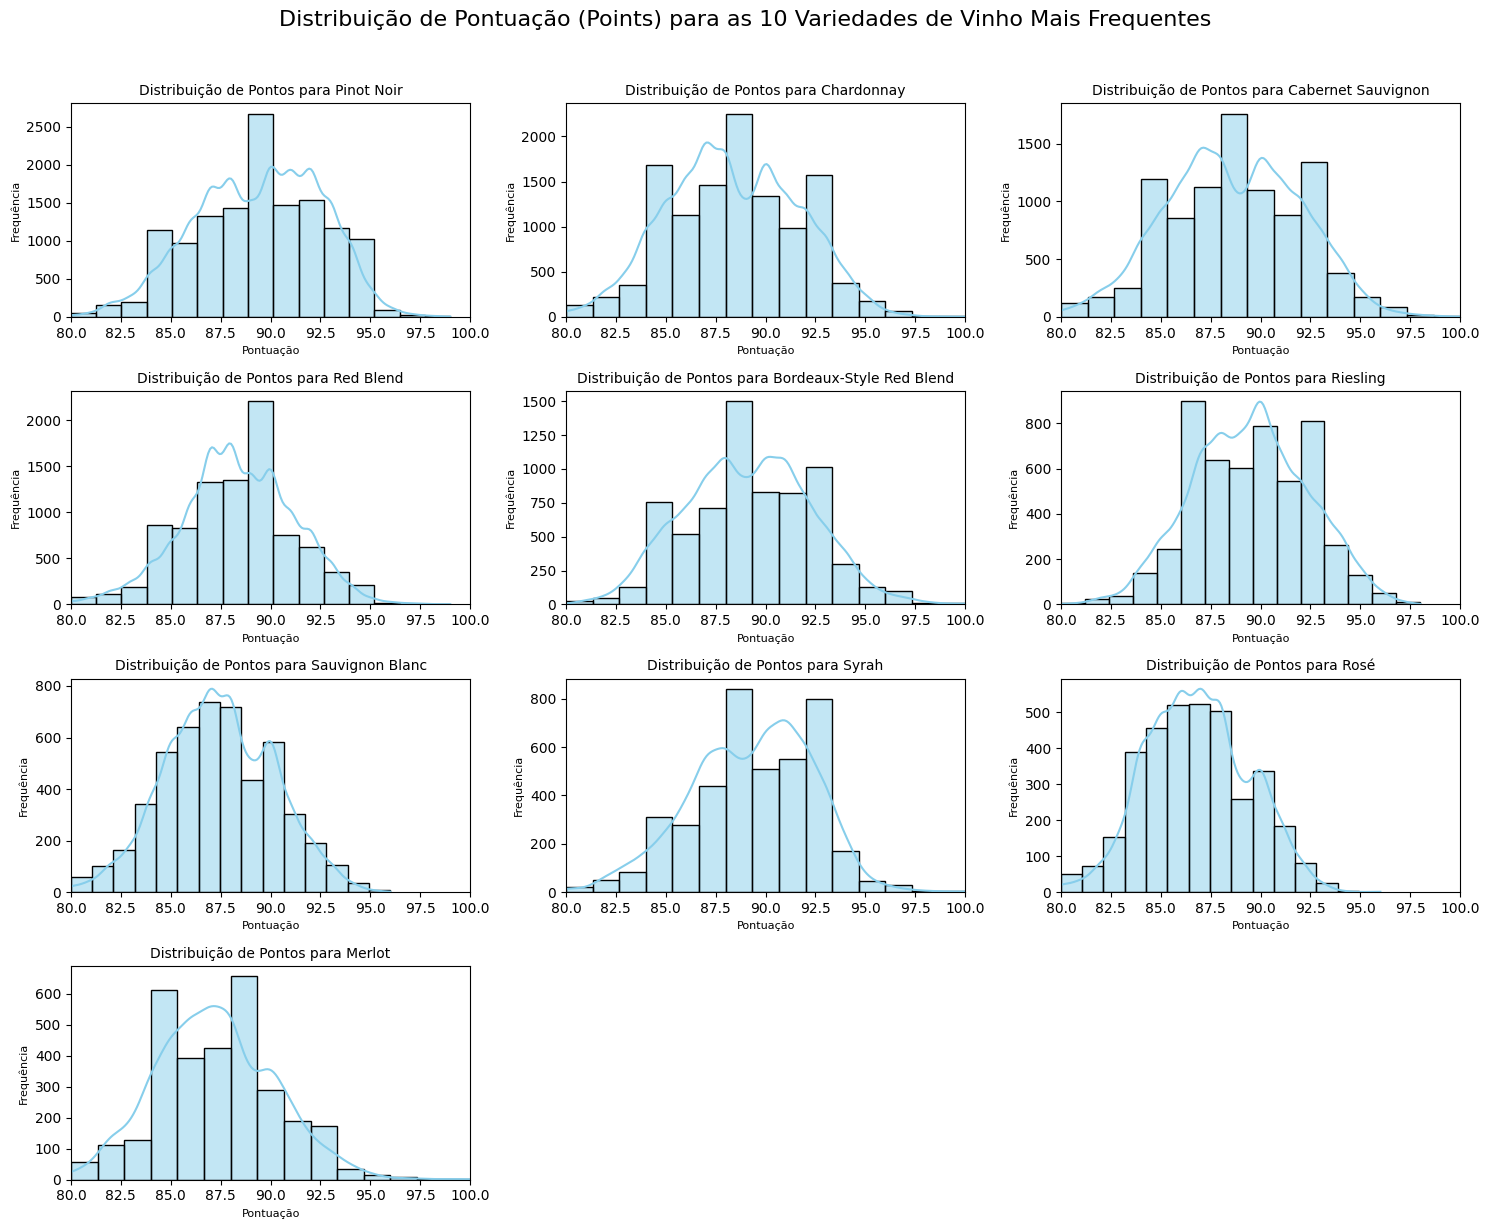

In [ ]:
# Encontre as 10 variedades mais frequentes
top_varieties = df_wine['variety'].value_counts().head(10).index.tolist()

# Crie um histograma para cada variedade
plt.figure(figsize=(15, 12))
for i, variety in enumerate(top_varieties):
    plt.subplot(4, 3, i + 1)
    sns.histplot(data=df_wine[df_wine['variety'] == variety], x='points', bins=15, kde=True, color='skyblue')
    plt.title(f'Distribuição de Pontos para {variety.title()}', fontsize=10)
    plt.xlabel('Pontuação', fontsize=8)
    plt.ylabel('Frequência', fontsize=8)
    plt.xlim(80, 100)
    plt.tight_layout()

plt.suptitle('Distribuição de Pontuação (Points) para as 10 Variedades de Vinho Mais Frequentes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

####*Análise*
Os 10 vinhos mais frequentes são:
- Pinot Noir
- Chardonnay
- Cabernet Sauvignon
- Red Blended
- Bordeaux
- Riesling
- Sauvingon Blanc
- Syrah
- Rosé
- Merlot

Para as 10 variedades de vinho mais frequentes, a distribuição das notas é bastante consistente, com a maioria dos vinhos recebendo pontuações acima de 85 até 90 e poucos, com nítida queda a partir dos 95 pontos. Isso indica que as notas dos vinhos mais comuns tendem a ser consistentemente boas ou muito boas.

O histograma mostra pouquíssimos vinhos com notas abaixo de 80. Isso pode indicar um viés no conjunto de dados, onde a maioria dos vinhos avaliados já são de uma qualidade aceitável, ou que vinhos de qualidade muito baixa simplesmente não são incluídos nas avaliações.

Para um modelo de Machine Learning, essa análise é valiosa. Ela confirma a importância da variável variety como um preditor-chave e sugere que o modelo pode ter um desempenho mais fácil e preciso para variedades com uma distribuição de notas mais consistente. Também levanta a questão do viés do dataset, que deve ser considerado em etapas futuras.

##Distribuição de preço por tipo e seus top 5 países de produção
Para as 10 variedades mais populares, analisaremos a distribuição de preços pelos 5 países que mais produzem cada variedade. Ajudará a identificar se a relação entre preço muda dependendo de onde o vinho é produzido.

Puxando os 10 vinhos mais frequentes e os 5 países que mais os produzem.

In [ ]:
# Encontre as 10 variedades mais frequentes
top_varieties = df_wine['variety'].value_counts().head(10).index.tolist()

# Prepare um DataFrame para o plot
plot_data = []

# Para cada variedade, encontre os 5 países que mais a produzem e colete os dados
for variety in top_varieties:
    df_variety = df_wine[df_wine['variety'] == variety]
    top_countries_for_variety = df_variety['country'].value_counts().head(5).index.tolist()

    df_filtered = df_variety[df_variety['country'].isin(top_countries_for_variety)].copy()
    df_filtered['top_variety'] = variety.title()
    plot_data.append(df_filtered)

df_plot = pd.concat(plot_data)

####Gráfico

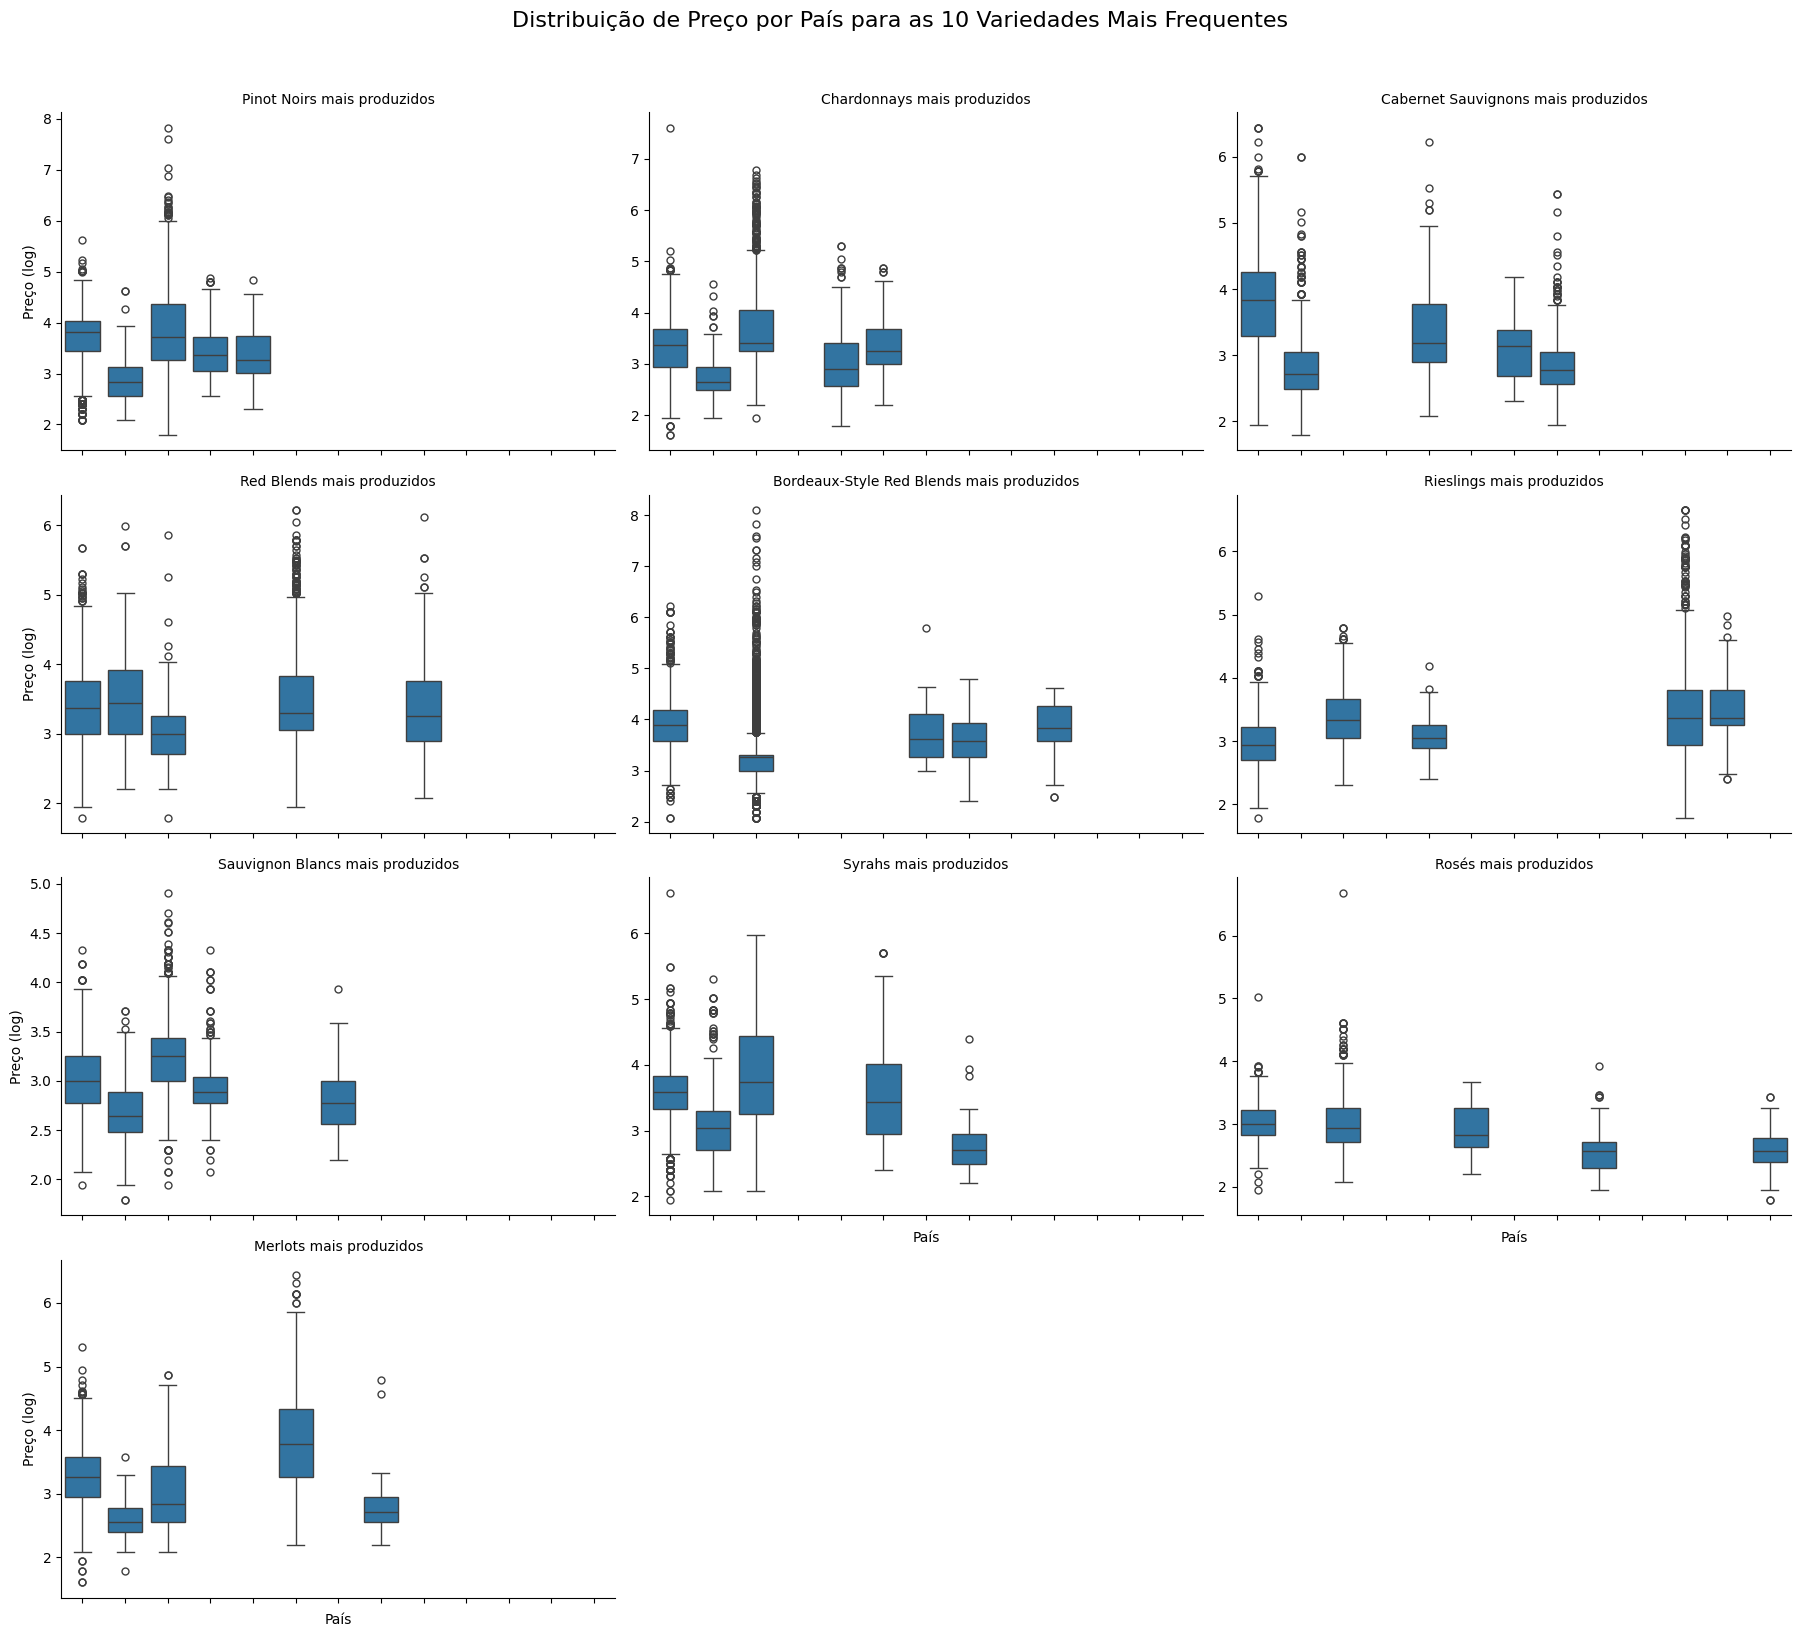

In [ ]:
# Crie o boxplot agrupado para o preço
g_price = sns.catplot(
    data=df_plot,
    x='country',
    y='log_preco',
    col='top_variety',
    kind='box',
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=False
)

# Adicione títulos e ajuste o layout
g_price.set_axis_labels('País', 'Preço (log)')
g_price.set_titles('{col_name}s mais produzidos')
plt.suptitle('Distribuição de Preço por País para as 10 Variedades Mais Frequentes', fontsize=16, y=1.02)

# Correção da rotação e alinhamento dos rótulos e adicionar o rótulo do eixo x para cada subplot
for ax in g_price.axes.flat:
    ax.set_xticks(ax.get_xticks())
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')

plt.tight_layout()
plt.show()

####*Análise*
O gráfico confirma que, para uma mesma variedade de vinho, a distribuição de preços varia significativamente dependendo do país produtor. Isso valida a hipótese de que a relação entre preço e tipo de vinho é inseparável da sua origem.

Essa análise visual é crucial para o modelo de Machine Learning. Ela demonstra que a variável country (país) é um fator de interação fundamental. Um modelo de recomendação que considere apenas a variedade pode errar nas previsões de preço.

## Geração dos Embedding usando [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)
O modelo mapeia Frases e Paragrafos em um plano vetorial de 384 dimensões, e pode ser usado para clusterizar sentido de palavras

In [ ]:
# ---------------------------------------------------
# 1. Agrupando o DataFrame para ser usado para gerar os Embeddings
# ---------------------------------------------------
df_grouped = df_wine.groupby('title').agg(
    points=('points', 'mean'),
    price=('price', 'mean'),
    sentiment=('sentiment', 'mean'),
    description=('description', lambda x: ' '.join(x)),
    tokens=('tokens', lambda x: list(itertools.chain.from_iterable(x)))
).reset_index()

print("DataFrame agrupado por título:")
display(df_grouped.head())

# ---------------------------------------------------
# 2. Inicializar modelo de embeddings semânticos
# ---------------------------------------------------
print("🔹 Carregando modelo de embeddings semânticos...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# ---------------------------------------------------
# 3. Criar embeddings das descrições dos vinhos
# ---------------------------------------------------
print("🔹 Gerando embeddings das descrições...")
df_grouped['embedding'] = list(model.encode(
    df_grouped['description'].fillna('').tolist(),
    normalize_embeddings=True,
    show_progress_bar=True
))

df_wine.to_parquet('wine_embedded_grouped.parquet', index=False)

🔹 Carregando modelo de embeddings semânticos...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# ---------------------------------------------------
# 4. Função para recomendar vinhos
# ---------------------------------------------------
def recomendar_vinho(df_wine, texto, top_n=5):
    """
    Recebe um texto de entrada e retorna os vinhos mais similares semanticamente.
    """

    # Gerar embedding do texto de entrada
    query_emb = sentence_model.encode([texto], normalize_embeddings=True)

    # Calcular similaridade com todas as descrições
    all_embeddings = np.vstack(df_wine['embedding'])
    sim = cosine_similarity(query_emb, all_embeddings).flatten()

    # Pegar os índices dos mais similares
    top_idx = sim.argsort()[-top_n:][::-1]

    # Retornar DataFrame com similaridade
    resultados = df_wine.iloc[top_idx][['description', 'tokens', 'title', 'variety', 'province']].copy()
    resultados['similaridade'] = sim[top_idx]

    return resultados.reset_index(drop=True)


# ---------------------------------------------------
# 5. Exemplo de uso
# ---------------------------------------------------
entrada = "spicy vinegar"
recomendacoes = recomendar_vinho(df_wine, entrada, top_n=1)

print("🍷 Recomendações mais próximas da sua descrição:\n")
print(recomendacoes[['title','similaridade', 'description']])

ValueError: could not convert string to float: np.str_('[')